In [1]:
import numpy as np
import tensorflow as tf
from mnist import MNIST
#import mnist_reader
import sys
import matplotlib.pyplot as plt

## Loading the MNIST fashion data
As the github repository of this dataset emphesizes, please see [https://github.com/zalandoresearch/fashion-mnist#get-the-data], we should download the data and placed it in data/fashion. Otherwise, Tensorflow will use the digit MNIST.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_fashion = input_data.read_data_sets('data/fashion')


Extracting data/fashion\train-images-idx3-ubyte.gz
Extracting data/fashion\train-labels-idx1-ubyte.gz
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Extracting data/fashion\t10k-labels-idx1-ubyte.gz


## Visulizing the images

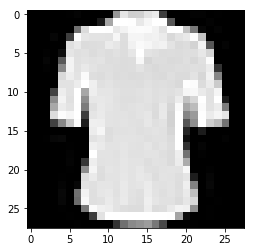

In [13]:
batch = mnist_fashion.train.next_batch(1)
plotData = batch[0]
plotData = plotData.reshape(28, 28)
plt.gray() # use this line if you don't want to see it in color
plt.imshow(plotData)
plt.show()

## Mapping 28x28 images to 20-dimensional vectors

In [4]:
from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 300
n_hidden3 = 20  # coding layer, reduces the dimsion 
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1) # layer 1
hidden2 = my_dense_layer(hidden1, n_hidden2) # Layer 2
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None) 
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None) ## logit values 
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits) ## Cost fucntion as cross entropy 
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # Adam optimizer
training_op = optimizer.minimize(loss) ## minizes dissimilarity between output images and the original images

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [5]:
import numpy as np

n_digits = 60
n_epochs = 30
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist_fashion.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist_fashion.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 25591.414 	Reconstruction loss: 23786.355 	Latent loss: 1805.0587
1 Train total loss: 24533.248 	Reconstruction loss: 22851.438 	Latent loss: 1681.8113
2 Train total loss: 24330.191 	Reconstruction loss: 22607.816 	Latent loss: 1722.3757
3 Train total loss: 23734.693 	Reconstruction loss: 22076.115 	Latent loss: 1658.5779
4 Train total loss: 23556.049 	Reconstruction loss: 21852.52 	Latent loss: 1703.5302
5 Train total loss: 24725.576 	Reconstruction loss: 23089.668 	Latent loss: 1635.9083
6 Train total loss: 23931.715 	Reconstruction loss: 22359.184 	Latent loss: 1572.5322
7 Train total loss: 23130.963 	Reconstruction loss: 21559.408 	Latent loss: 1571.554
8 Train total loss: 23807.45 	Reconstruction loss: 22179.57 	Latent loss: 1627.8782
9 Train total loss: 24524.404 	Reconstruction loss: 22927.516 	Latent loss: 1596.8889
10 Train total loss: 24212.664 	Reconstruction loss: 22563.326 	Latent loss: 1649.3374
11 Train total loss: 24293.297 	Reconstruction loss: 2267

## Visualizing the images we generated

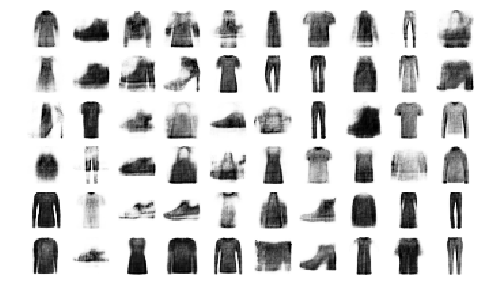

In [6]:
plt.figure(figsize=(8,50)) # not shown in the book
shape = [28,28]
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    image = outputs_val[iteration]
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

## Can we use GPU? 
Yes, but we need to install cuda packges, see [http://blog.nitishmutha.com/tensorflow/2017/01/22/TensorFlow-with-gpu-for-windows.html]. 

## Loading teh data with the URL

In [15]:
data_url = input_data.read_data_sets('data/fashion', source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')


Extracting data/fashion\train-images-idx3-ubyte.gz
Extracting data/fashion\train-labels-idx1-ubyte.gz
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Extracting data/fashion\t10k-labels-idx1-ubyte.gz
